<img src="https://raw.githubusercontent.com/euroargodev/argopy/master/docs/_static/argopy_logo_long.png" alt="argopy logo" width="200"/> 

# Visualise one float BGC data

This notebook shows how to:
- download BGC-Argo data
- download info from Argo NVS Reference Tables about a parameter
- plot a map with float trajectory
- plot float data

## Import and set-up

In [1]:
from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map  # This is a function to easily make maps 

# Make a fresh start
import argopy
argopy.reset_options()
argopy.clear_cache()
argopy.set_options(cachedir='cache_bgc')

#
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import xarray as xr
xr.set_options(display_expand_attrs = False)

/Users/gmaze/miniconda3/envs/argopy-docs/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Find a float to work with

For this demo notebook, we'll randomly select a BGC float to work with.

For your own use, you can simply overwrite the ``WMO`` variable content with your favorite float.

In [2]:
# Load the BGC-synthetic profiles index
# rq: we work with synthetic profiles because that's the only dataset available from the erddap at this point (2023/07/21)
idx = ArgoIndex(index_file='bgc-s').load()  
idx

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
Loaded: True (287455 records)
Searched: False

In [3]:
# Select one random WMO:
WMO_list = idx.read_wmo(index=True)
WMO = WMO_list[np.random.randint(len(WMO_list))]
print('We will work with float: %i' % WMO)

We will work with float: 6901773


In [4]:
# Search for all profiles from this float:
idx.search_wmo(WMO)

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
Loaded: True (287455 records)
Searched: True (295 matches, 0.1026%)

## Load all possible data from this float

In [5]:
%%time
if idx.N_MATCH < 200:
    f = DataFetcher(ds='bgc', mode='expert', params='all').float(WMO).load()
else:    
    print("This float has a large number of profiles (%i) and it could be tuff for the erddap server "\
          "to retrieve so much data, so we limit download to 200 profiles" % idx.N_MATCH)
    argopy.set_options(api_timeout=120)
    f = DataFetcher(ds='bgc', mode='expert', params='all').profile(WMO, np.arange(0, 200)).load()
f

This float has a large number of profiles (295) and it could be tuff for the erddap server to retrieve so much data, so we limit download to 200 profiles
CPU times: user 1min 3s, sys: 1.08 s, total: 1min 4s
Wall time: 1min 18s


<datafetcher.erddap>
Name: Ifremer erddap Argo BGC data fetcher for profiles
API: https://erddap.ifremer.fr/erddap
Domain: bgc;WMO6901773_CYC0_CYC1_CYC2_ ... 95_CYC196_CYC197_CYC198_CYC199
BGC variables: ['BBP700', 'CDOM', 'CHLA', 'DOWNWELLING_PAR', 'DOWN_IRRADIANCE380', 'DOWN_IRRADIANCE412', 'DOWN_IRRADIANCE490', 'DOXY', 'NITRATE', 'PRES', 'PSAL', 'TEMP']
BGC 'must be measured' variables: []
Performances: cache=False, parallel=False
User mode: expert
Dataset: bgc
Loaded: True

In [6]:
# Check the data:
ds = f.data
ds

<xarray.Dataset>
Dimensions:                            (N_POINTS: 160310)
Coordinates:
    LATITUDE                           (N_POINTS) float64 33.54 33.54 ... 33.1
    LONGITUDE                          (N_POINTS) float64 28.45 28.45 ... 33.28
    TIME                               (N_POINTS) datetime64[ns] 2015-05-21T1...
  * N_POINTS                           (N_POINTS) int64 0 1 2 ... 160308 160309
Data variables: (12/78)
    BBP700                             (N_POINTS) float32 ...
    BBP700_ADJUSTED                    (N_POINTS) float32 ...
    BBP700_ADJUSTED_ERROR              (N_POINTS) float32 ...
    BBP700_ADJUSTED_QC                 (N_POINTS) int64 0 0 0 0 0 ... 0 0 0 0 0
    BBP700_DATA_MODE                   (N_POINTS) <U1 'R' 'R' 'R' ... 'R' 'R'
    BBP700_QC                          (N_POINTS) int64 2 0 0 2 0 ... 2 0 0 0 2
    ...                                 ...
    TEMP_ADJUSTED                      (N_POINTS) float32 ...
    TEMP_ADJUSTED_ERROR                (N_POINTS) float32 ...
    TEMP_ADJUSTED_QC                   (N_POINTS) int64 8 8 1 8 1 ... 8 1 1 8 4
    TEMP_DATA_MODE                     (N_POINTS) <U1 'D' 'D' 'D' ... 'D' 'D'
    TEMP_QC                            (N_POINTS) int64 8 1 1 8 1 ... 8 1 1 1 8
    TIME_QC                            (N_POINTS) int64 1 1 1 1 1 ... 1 1 1 1 1
Attributes: (7)

## Make a map with float trajectory

Rq: we could have done this without downloading the data by working directly with an ArgoIndex

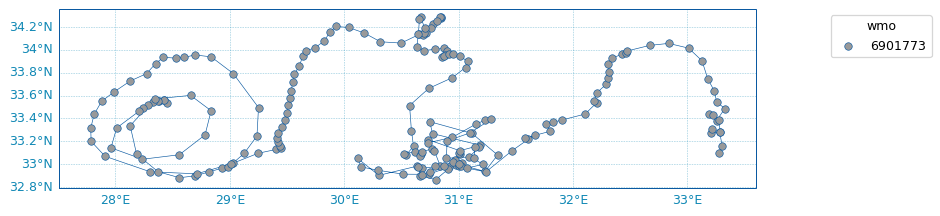

In [7]:
scatter_map(f.index, set_global=False);

We can also make a scatter map with a BGC parameter data mode.

Since the float was randomly selected, we don't know which BGC parameter are available, so we need to first make a list of these:

In [8]:
# ``f.fetcher.indexfs`` is the ArgoIndex instance used by the erddap fetcher ``f``
idx = f.fetcher.indexfs  # rq: argopy expert trick

# Get the list of BGC parameters:
bgc_params = idx.read_params()
[bgc_params.remove(p) for p in ['PRES', 'TEMP', 'PSAL']]  # Remove core variables from the list
bgc_params

['BBP700',
 'CDOM',
 'CHLA',
 'DOWNWELLING_PAR',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE412',
 'DOWN_IRRADIANCE490',
 'DOXY',
 'NITRATE']

## Make a map with one BGC parameter data mode

In [9]:
# Randomly select one BGC parameter to work with:
a_param = bgc_params[np.random.randint(len(bgc_params))]
a_param

'BBP700'

In [10]:
# Get a DataFrame with Argo index for this float profiles:
df = f.to_index(full=True)
df

file                date  \
0     coriolis/6901773/profiles/SD6901773_001.nc 2015-05-22 11:46:00   
1    coriolis/6901773/profiles/SD6901773_001D.nc 2015-05-21 17:38:00   
2     coriolis/6901773/profiles/SD6901773_002.nc 2015-05-23 11:45:00   
3    coriolis/6901773/profiles/SD6901773_002D.nc 2015-05-22 13:30:00   
4     coriolis/6901773/profiles/SD6901773_003.nc 2015-05-24 11:38:00   
..                                           ...                 ...   
290   coriolis/6901773/profiles/SD6901773_288.nc 2020-01-25 09:36:00   
291   coriolis/6901773/profiles/SD6901773_289.nc 2020-02-01 09:34:00   
292   coriolis/6901773/profiles/SD6901773_290.nc 2020-02-08 09:36:00   
293   coriolis/6901773/profiles/SD6901773_291.nc 2020-02-15 09:36:00   
294   coriolis/6901773/profiles/SD6901773_292.nc 2020-02-22 09:46:00   

     latitude  longitude ocean  profiler_code institution_code  \
0      33.563     28.425     A            836               IF   
1      33.537     28.447     A            836               IF   
2      33.556     28.375     A            836               IF   
3      33.563     28.424     A            836               IF   
4      33.541     28.330     A            836               IF   
..        ...        ...   ...            ...              ...   
290    34.122     35.076     A            836               IF   
291    33.921     35.001     A            836               IF   
292    33.886     34.866     A            836               IF   
293    33.912     34.717     A            836               IF   
294    34.096     34.822     A            836               IF   

                                            parameters parameter_data_mode  \
0    PRES TEMP PSAL DOXY DOWN_IRRADIANCE380 DOWN_IR...        DDDDDDDDDRRD   
1    PRES TEMP PSAL DOXY DOWN_IRRADIANCE380 DOWN_IR...        DDDDRRRRDRRD   
2    PRES TEMP PSAL DOXY DOWN_IRRADIANCE380 DOWN_IR...        DDDDDDDDDRRD   
3    PRES TEMP PSAL DOXY DOWN_IRRADIANCE380 DOWN_IR...        DDDDRRRRDRRD   
4    PRES TEMP PSAL DOXY DOWN_IRRADIANCE380 DOWN_IR...        DDDDDDDDDRRD   
..                                                 ...                 ...   
290  PRES TEMP PSAL DOXY DOWN_IRRADIANCE380 DOWN_IR...        DDDDDDDDDRRD   
291  PRES TEMP PSAL DOXY DOWN_IRRADIANCE380 DOWN_IR...        DDDDDDDDDRRD   
292  PRES TEMP PSAL DOXY DOWN_IRRADIANCE380 DOWN_IR...        DDDDDDDDDRRD   
293  PRES TEMP PSAL DOXY DOWN_IRRADIANCE380 DOWN_IR...        DDDDDDDDDRRD   
294  PRES TEMP PSAL DOXY DOWN_IRRADIANCE380 DOWN_IR...        DDDDDDDDDRRD   

            date_update      wmo  cyc      institution profiler  
0   2022-09-06 11:40:37  6901773    1  Ifremer, France  Unknown  
1   2022-09-06 11:40:23  6901773    1  Ifremer, France  Unknown  
2   2022-09-06 11:41:05  6901773    2  Ifremer, France  Unknown  
3   2022-09-06 11:40:50  6901773    2  Ifremer, France  Unknown  
4   2022-09-06 11:41:31  6901773    3  Ifremer, France  Unknown  
..                  ...      ...  ...              ...      ...  
290 2022-09-06 12:46:03  6901773  288  Ifremer, France  Unknown  
291 2022-09-06 12:46:15  6901773  289  Ifremer, France  Unknown  
292 2022-09-06 12:46:29  6901773  290  Ifremer, France  Unknown  
293 2022-09-06 12:46:42  6901773  291  Ifremer, France  Unknown  
294 2022-09-06 12:46:56  6901773  292  Ifremer, France  Unknown  

[295 rows x 14 columns]

In [11]:
# To make the scatter map, we need to have the data mode available in one DataFrame column
# so we need to add a new column with the DATA_MODE of the PARAMETER:
df["variables"] = df["parameters"].apply(lambda x: x.split())
df["%s_DM" % a_param] = df.apply(lambda x: x['parameter_data_mode'][x['variables'].index(a_param)] if a_param in x['variables'] else '', axis=1)

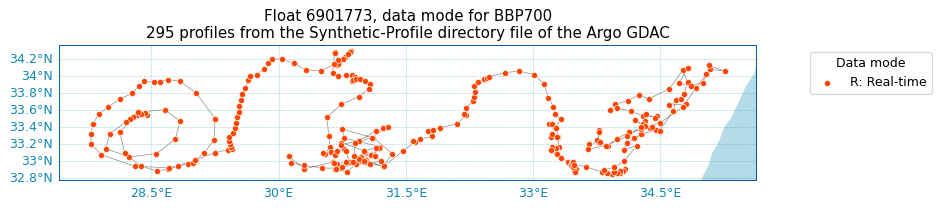

In [12]:
# Finally plot the map:
fig, ax = scatter_map(df,
                        hue="%s_DM" % a_param,
                        cmap="data_mode",
                        markersize=24,
                        markeredgecolor='w',
                        traj_color='gray',
                        legend_title='Data mode')
ax.set_title("Float %i, data mode for %s\n%i profiles from the %s" % (WMO, a_param, idx.N_MATCH, 
                                                            idx.convention_title));

## Plot raw data

In [96]:
# Define usefull functions

def get_vlabel(this_ds, this_v):
    attrs = this_ds[this_v].attrs
    if 'standard_name' in attrs:
        name = attrs['standard_name']
    elif 'long_name' in attrs:
        name = attrs['long_name']
    else:
        name = this_v
    units = attrs['units'] if 'units' in attrs else None
    return "%s\n[%s]" % (name, units) if units else name


# Define a parameter plotting function
def param_scatter(this_ds, 
                  this_param, 
                  this_x='CYCLE_NUMBER', 
                  this_y='PRES', 
                  figsize=(18, 6), 
                  cmap=mpl.colormaps['gist_ncar'],
                  vmin=None,
                  vmax=None,
                  s=4
                 ):

    # Read variables for the plot:
    x, y = this_ds[this_x], this_ds[this_y]
    if "INTERPOLATED" in this_y:
        x_bounds, y_bounds = np.meshgrid(x, y, indexing='ij')
    c = this_ds[this_param]

    #
    fig, ax = plt.subplots(dpi=90, figsize=figsize)

    if vmin == 'attrs':
        vmin = c.attrs['valid_min'] if 'valid_min' in c.attrs else None
    if vmax == 'attrs':
        vmax = c.attrs['valid_max'] if 'valid_max' in c.attrs else None
    if vmin is None:
        vmin = np.percentile(c, 10)
    if vmax is None:
        vmax = np.percentile(c, 90)
    
    if "INTERPOLATED" in this_y:
        m = ax.pcolormesh(x_bounds, y_bounds, c, cmap=cmap, vmin=vmin, vmax=vmax) 
    else:
        m = ax.scatter(x, y, c=c, cmap=cmap, s=s, vmin=vmin, vmax=vmax) 
        ax.set_facecolor('lightgrey')

    cbar = plt.colorbar(m)
    cbar.ax.set_ylabel(get_vlabel(this_ds, this_param), rotation=90)

    ylim = ax.get_ylim()
    if 'PRES' in this_y:
        ax.invert_yaxis()
        y_bottom, y_top = np.max(ylim), np.min(ylim)
    else:
        y_bottom, y_top = ylim

    if this_x == 'CYCLE_NUMBER':
        ax.set_xlim([np.min(this_ds[this_x])-1, np.max(this_ds[this_x])+1])
    if 'PRES' in this_y:
        ax.set_ylim([y_bottom, 0])

    # Add markers on all sample positions:
    # p = ax.plot(ds[this_x], ds['PRES'], markersize=0.1, marker='.', color='darkgray', linestyle='', alpha=0.5)

    # Add cycle number ticks along the x-axis:
    if this_x == 'CYCLE_NUMBER':
        cycs = np.unique(this_ds['CYCLE_NUMBER'])
        for c in cycs:
            ax.text(c, y_bottom, "|", fontdict={'weight': 'bold'})

    #        
    ax.set_xlabel(get_vlabel(this_ds, this_x))
    ax.set_ylabel(get_vlabel(this_ds, this_y))
    
    return fig, ax



13.89900016784668 19.75200080871582


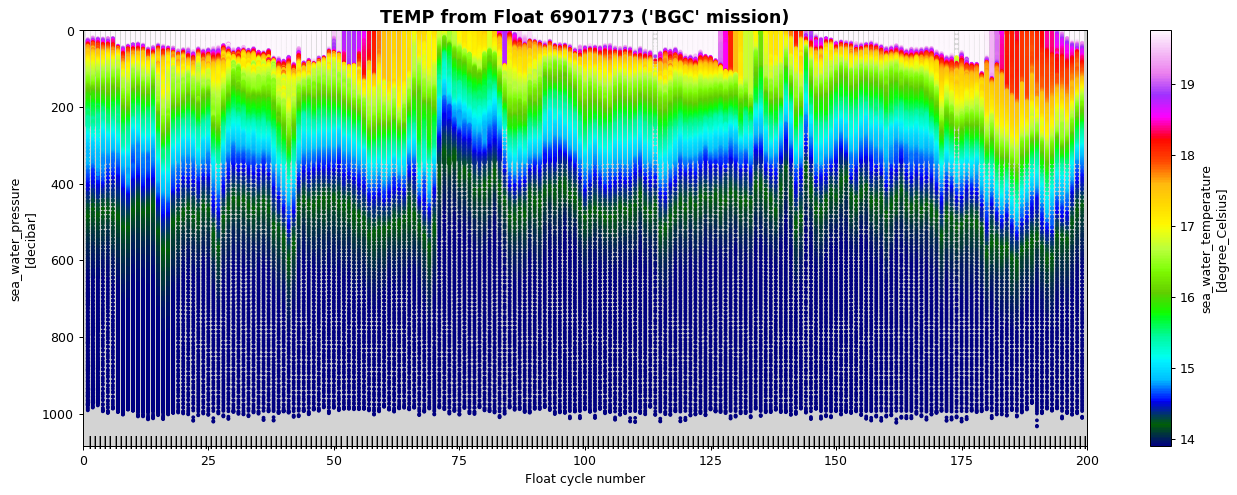

In [97]:
fig, ax = param_scatter(ds, 'TEMP')
ax.set_title("%s from Float %i ('%s' mission)" % ('TEMP', WMO, f.mission), fontdict={'weight': 'bold', 'size': 14});

38.75 39.5


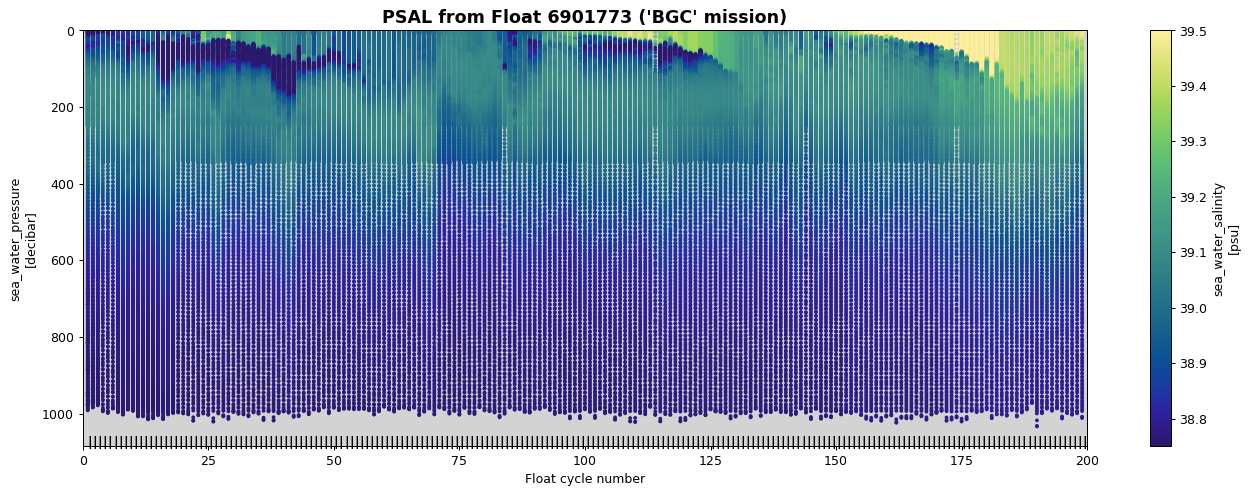

In [99]:
fig, ax = param_scatter(ds, 'PSAL', cmap=cmocean.cm.haline, vmin=38.75, vmax=39.5)
ax.set_title("%s from Float %i ('%s' mission)" % ('PSAL', WMO, f.mission), fontdict={'weight': 'bold', 'size': 14});

0.0002 0.0007


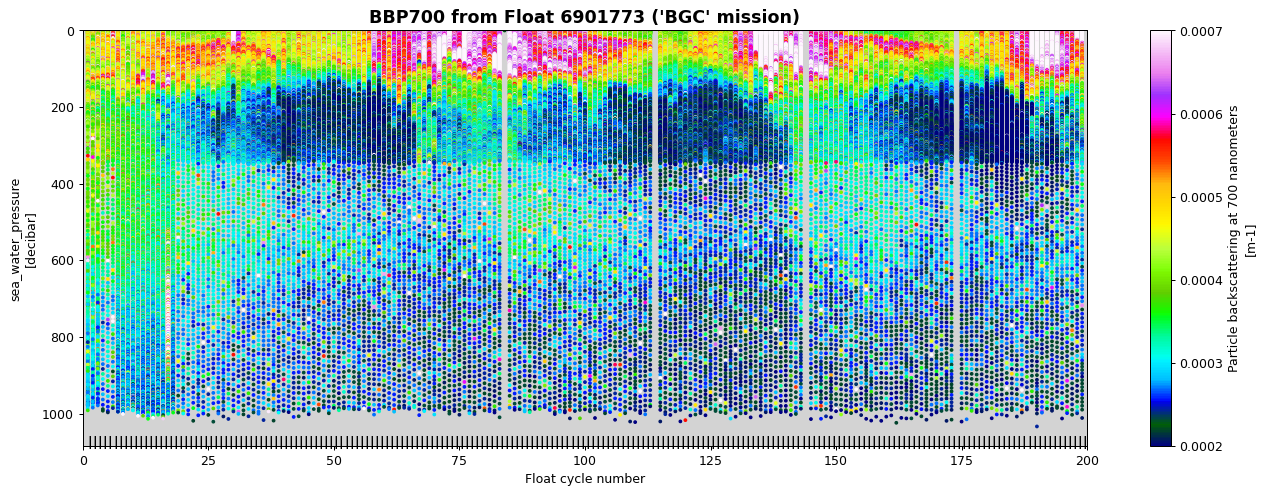

In [98]:
fig, ax = param_scatter(ds, a_param, vmin=20e-5, vmax=70e-5)
ax.set_title("%s from Float %i ('%s' mission)" % (a_param, WMO, f.mission), fontdict={'weight': 'bold', 'size': 14});

## Plot binned data

In [109]:
bins = np.arange(0.0, np.max(ds["PRES"]), 10.0)
ds_binned = ds.argo.groupby_pressure_bins(bins=bins, select='median')

0.0002 0.0007


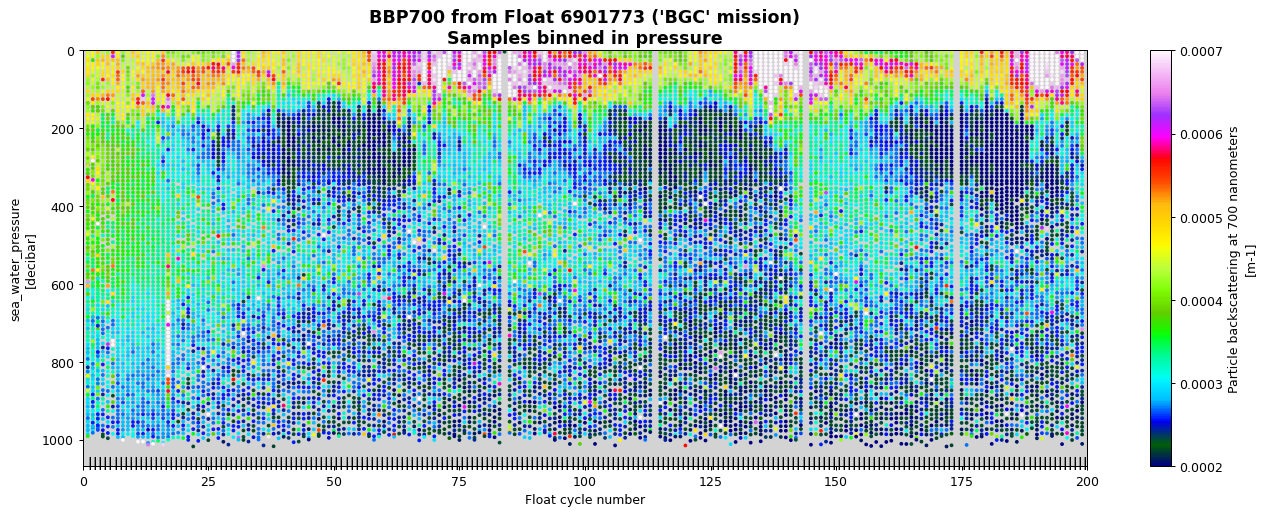

In [110]:
fig, ax = param_scatter(ds_binned, a_param, vmin=20e-5 if a_param=='BBP700' else None, vmax=70e-5 if a_param=='BBP700' else None)
ax.set_title("%s from Float %i ('%s' mission)\nSamples binned in pressure" % (a_param, WMO, f.mission), fontdict={'weight': 'bold', 'size': 14});

In [102]:
dsp = ds.argo.point2profile()
# std_lev = np.arange(0, np.round(ds['PRES'].max())-200, 25.0)
std_lev = np.arange(0., 1000., 10.0)
dsi = dsp.argo.interp_std_levels(std_lev)
dsi

<xarray.Dataset>
Dimensions:                       (N_PROF: 157, PRES_INTERPOLATED: 100)
Coordinates:
  * N_PROF                        (N_PROF) int64 3 6 7 9 10 ... 198 199 200 201
    LATITUDE                      (N_PROF) float64 33.56 33.51 ... 33.16 33.1
    LONGITUDE                     (N_PROF) float64 28.42 28.29 ... 33.3 33.28
    TIME                          (N_PROF) datetime64[ns] 2015-05-22T11:46:00...
  * PRES_INTERPOLATED             (PRES_INTERPOLATED) float64 0.0 10.0 ... 990.0
Data variables: (12/40)
    BBP700                        (N_PROF, PRES_INTERPOLATED) float32 0.00042...
    BBP700_ADJUSTED               (N_PROF) float32 nan nan nan ... nan nan nan
    BBP700_DATA_MODE              (N_PROF) <U1 'R' 'R' 'R' 'R' ... 'R' 'R' 'R'
    CDOM                          (N_PROF, PRES_INTERPOLATED) float32 1.086 ....
    CDOM_ADJUSTED                 (N_PROF) float32 nan nan nan ... nan nan nan
    CDOM_DATA_MODE                (N_PROF) <U1 'R' 'R' 'R' 'R' ... 'R' 'R' 'R'
    ...                            ...
    PSAL                          (N_PROF, PRES_INTERPOLATED) float32 38.73 ....
    PSAL_ADJUSTED                 (N_PROF, PRES_INTERPOLATED) float32 38.76 ....
    PSAL_DATA_MODE                (N_PROF) <U1 'D' 'D' 'D' 'D' ... 'D' 'D' 'D'
    TEMP                          (N_PROF, PRES_INTERPOLATED) float32 21.43 ....
    TEMP_ADJUSTED                 (N_PROF, PRES_INTERPOLATED) float32 21.36 ....
    TEMP_DATA_MODE                (N_PROF) <U1 'D' 'D' 'D' 'D' ... 'D' 'D' 'D'
Attributes: (8)

In [20]:
f.dashboard()